# Evaluate the Generated Data


In [12]:
# Set CUDA Device Before Operations: Make sure that you set the CUDA device before performing any operations that would require GPU computation.

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize CUDA Context: If you're using an environment where the CUDA context might 
# not be automatically initialized (like in some Jupyter notebook configurations), 
# you can manually initialize it by running a simple CUDA operation before your main computations:

if torch.cuda.is_available():
    _ = torch.rand(1, device='cuda')

1. 读取表格数据

In [1]:
# -- coding: utf-8 --
# import synthetic data vault libraries
# !pip install sdv
import os
import pandas as pd
data_pd = pd.read_csv('Emergency_CallCenter.csv')
data_pd.head()

,Time Interval 1,Time Interval 2,Time Interval 3,Time Interval 4,Time Interval 5,Time Interval 6,Time Interval 7,Time Interval 8,Time Interval 9,Time Interval 10,...,Time Interval 41,Time Interval 42,Time Interval 43,Time Interval 44,Time Interval 45,Time Interval 46,Time Interval 47,Time Interval 48,Time Interval 49,Time Interval 50
0,0.000000,0.000000,1.516667,0.000000,0.0,3.316667,0.000000,0.000000,0.000000,0.133333,...,2.616667,0.000000,0.000000,1.250000,0.000000,0.866667,0.000000,0.000000,0.583333,0.000000
1,3.050000,0.783333,1.066667,0.000000,0.0,2.816667,0.000000,12.766667,0.016667,1.316667,...,0.000000,0.816667,0.000000,0.000000,3.750000,1.116667,0.000000,0.000000,0.000000,0.000000
2,6.966667,0.000000,1.866667,0.000000,0.0,7.133333,2.166667,0.000000,10.816667,0.000000,...,9.233333,0.000000,0.000000,7.166667,6.266667,0.000000,1.616667,0.000000,2.516667,0.000000
3,13.216667,4.450000,5.466667,1.233333,0.0,9.800000,18.150000,0.000000,1.100000,0.000000,...,3.566667,0.000000,12.483333,0.000000,0.000000,6.183333,0.000000,3.900000,3.283333,0.000000
4,11.650000,0.000000,6.566667,0.583333,0.0,3.033333,0.000000,4.200000,0.000000,1.300000,...,11.000000,0.000000,0.000000,1.400000,0.000000,4.916667,0.000000,3.416667,0.000000,1.283333


2. 定义评价指标方法：Column Shapes（FC） 和 Column Pair Trends（FR）

In [2]:
%%writefile SVDevaluation.py
import pandas as pd
import sdv.evaluation.single_table as sdv_st
from sdv.metadata import SingleTableMetadata


def svd_evaluation(real_data, synthetic_data, savepath, show=False):
    # svd evaluation
    metadata = SingleTableMetadata()  # build a metadata for evaluation (from SDV)
    metadata.detect_from_dataframe(data=real_data)
    quality_report = sdv_st.evaluate_quality(  # generate quality report
        real_data,
        synthetic_data,
        metadata=metadata
    )
    print(quality_report)  # print quality report

    properties_dataframe = quality_report.get_properties()
    Column_Shapes = properties_dataframe.iloc[0, 1]
    Column_Pair_Trends = properties_dataframe.iloc[1, 1]
    print('Column Shapes:', Column_Shapes)
    print('Column Pair Trends:', Column_Pair_Trends)
    properties_dataframe.to_csv(savepath + '_properties_dataframe.csv', index=False)

    if show:
        # plot Column Shapes -> referred to the "Fidelity Column" in the paper
        fig = quality_report.get_visualization(property_name='Column Shapes')
        fig.write_html(savepath + '_Column_Shapes.html')
        fig.show()
        # plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
        fig = quality_report.get_visualization(property_name='Column Pair Trends')
        fig.write_html(savepath + '_Column_Pair_Trends.html')
        fig.show()
    return Column_Shapes, Column_Pair_Trends


if __name__ == '__main__':
    # 假设我们有一些示例的真实数据和合成数据
    # 这里我们只是简单地创建两个包含随机数的DataFrame作为示例
    real_data = pd.DataFrame({
        'A': [1, 2, 3, 4, 5],
        'B': [5, 4, 3, 2, 1],
        'C': [2, 3, 4, 5, 6]
    })

    synthetic_data = pd.DataFrame({
        'A': [1.1, 1.9, 2.8, 4.5, 4.9],
        'B': [5.2, 4.3, 3.4, 2.5, 1.7],
        'C': [2.1, 3.4, 4.5, 5.6, 6.7]
    })

    # 定义一个保存路径
    savepath = "./"

    # 调用 svd_evaluation 函数
    svd_evaluation(real_data, synthetic_data, savepath)


Writing SVDevaluation.py


3. Auto detect metadata 获取输入表格数据的列类型和特征

This is an example of a JSON file describing a single table.

参考：
- https://docs.sdv.dev/sdv/single-table-data/data-preparation/single-table-metadata-api
- https://docs.sdv.dev/sdv/reference/metadata-spec/single-table-metadata-json

可视化报错：failed to execute WindowsPath(‘dot‘), make sure the Graphviz executables are on
解决：

1. 先卸载　pip uninstall graphviz
2. 安装windows版的 https://graphviz.org/，勾选系统路径，安装到C:\Users\x\anaconda3\Lib\site-packages\Graphviz
3. 最后安装 pip install graphviz

参考：
- https://blog.csdn.net/gj18405655459/article/details/123234866
- https://blog.csdn.net/m0_52118763/article/details/119919644

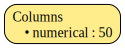

In [8]:
from sdv.metadata import SingleTableMetadata

# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data_pd)
python_dict = metadata.to_dict()
metadata.visualize(
    show_table_details='full',
    output_filepath='my_metadata_full.png'
)
metadata.visualize(
    show_table_details='summarized',
    output_filepath='my_metadata_summarized.png'
)

4. 使用特定合成器，合成新的数据

In [9]:
metadata.save_to_json(filepath='my_metadata_v1.json')

#-----------------------------------------------Gaussian Copula Synthesizer------------------------------------------------------------#
result_path = 'Gaussian/'
os.makedirs(result_path, exist_ok=True)


from sdv.single_table import GaussianCopulaSynthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(data_pd)
synthetic_data = synthesizer.sample(num_rows=data_pd.shape[0])
synthetic_data.to_csv('Gaussian/samples.csv', index=False)

5. 评价合成数据

In [10]:
# fidelity evaluation
from SVDevaluation import svd_evaluation
Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)


Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████| 50/50 [00:00<00:00, 1003.70it/s]|
Column Shapes Score: 49.6%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████| 1225/1225 [00:05<00:00, 217.99it/s]|
Column Pair Trends Score: 97.33%

Overall Score (Average): 73.46%

Column Shapes: 0.49596412556053815
Column Pair Trends: 0.9733100905688502


In [13]:
#-----------------------------------------------CTGAN Synthesizer------------------------------------------------------------#
result_path = 'CTGAN/'
os.makedirs(result_path, exist_ok=True)
from sdv.single_table import CTGANSynthesizer
synthesizer = CTGANSynthesizer(metadata, epochs=1)
synthesizer.fit(data_pd)
synthetic_data = synthesizer.sample(num_rows=data_pd.shape[0])
synthetic_data.to_csv('CTGAN/samples.csv', index=False)


In [14]:
# fidelity evaluation
from SVDevaluation import svd_evaluation
Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)


Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████| 50/50 [00:00<00:00, 1024.44it/s]|
Column Shapes Score: 65.65%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████| 1225/1225 [00:05<00:00, 221.80it/s]|
Column Pair Trends Score: 97.05%

Overall Score (Average): 81.35%

Column Shapes: 0.6564573991031389
Column Pair Trends: 0.9704907020820224


In [15]:
#-------------------------------------------------TVAE Synthesizer-----------------------------------------------------------#
result_path = 'TVAE/'
os.makedirs(result_path, exist_ok=True)
from sdv.single_table import TVAESynthesizer
synthesizer = TVAESynthesizer(metadata, epochs=1)

synthesizer.fit(data_pd)
synthetic_data = synthesizer.sample(num_rows=data_pd.shape[0])
synthetic_data.to_csv('TVAE/samples.csv', index=False)


In [16]:
# fidelity evaluation
from SVDevaluation import svd_evaluation
Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)


Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████| 50/50 [00:00<00:00, 1090.14it/s]|
Column Shapes Score: 52.19%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████| 1225/1225 [00:05<00:00, 222.70it/s]|
Column Pair Trends Score: 96.53%

Overall Score (Average): 74.36%

Column Shapes: 0.5219282511210762
Column Pair Trends: 0.9653081250996076


In [17]:
#-------------------------------------------------只有生成数据的结果 ：NIM----------------------------------------------------------#


result_path = 'NIM/'
synthetic_data = pd.read_csv('NIM/samples.csv')
# fidelity evaluation
from SVDevaluation import svd_evaluation
Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)


# import time
# time.sleep(10)


Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████| 50/50 [00:00<00:00, 1044.06it/s]|
Column Shapes Score: 48.77%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████| 1225/1225 [00:05<00:00, 222.72it/s]|
Column Pair Trends Score: 97.69%

Overall Score (Average): 73.23%

Column Shapes: 0.48771300448430494
Column Pair Trends: 0.976938948544229


In [18]:
#-------------------------------------------------Our-----------------------------------------------------------#
result_path = 'Our/'
synthetic_data = pd.read_csv('Our/samples.csv')
# fidelity evaluation
from SVDevaluation import svd_evaluation
Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=data_pd, synthetic_data=synthetic_data, savepath=result_path + 'svd_evaluation', show=True)


Generating report ...

(1/2) Evaluating Column Shapes: |███████████████████████████████████████████████████| 50/50 [00:00<00:00, 1230.07it/s]|
Column Shapes Score: 92.34%

(2/2) Evaluating Column Pair Trends: |███████████████████████████████████████████| 1225/1225 [00:05<00:00, 223.04it/s]|
Column Pair Trends Score: 95.58%

Overall Score (Average): 93.96%

Column Shapes: 0.9234053811659193
Column Pair Trends: 0.9558220432754042
